In [1]:
import numpy as np
from numpy.random import uniform, randn

import matplotlib.pyplot as plt

import math
from math import sin, cos, pi, sqrt

import random

In [2]:
# Givens
n = 2
s0 = np.array([1,1])
A = np.array([[0, 1],
             [-1, 0]])
T = 1 # sec
dt = 0.1
N = int(T / dt)
tvec = tvec = np.linspace(0, 1, N+1)  # for plotting

variance = 0.1
sigma = sqrt(variance)


In [3]:
# noise: normal distributions with variance 0.1

def noise_distribution(mean, std):
    '''
    Generates normal distribution 
    '''
    noise = np.zeros(2)
    N = 1
    noise[0] = mean[0] + (randn(N) * std)
    noise[1] = mean[1] + (randn(N) * std)
    return noise.T


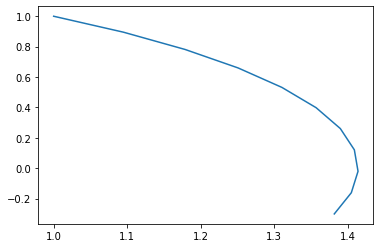

In [4]:
# Initial Trajectory Given Dynamics - For the measurement value and computing error

def simulate_init_traj(x0):
    x0 = np.copy(x0)
    xtraj = np.zeros((n,N+1))
    xtraj[:, 0] = x0          # initial condition at N=0
    
    
    for i in range(1, N+1):
        xtraj[:,i] = RK4(x0)
        x0 = np.copy(xtraj[:,i])
    
    return xtraj

def RK4(xt):
    new_xt = np.zeros(n)
    
    k1 = dt * dynamics(xt)
    k2 = dt * dynamics( xt+(k1/2.))
    k3 = dt * dynamics( xt+(k2/2.))
    k4 = dt * dynamics( xt+k3)
    new_xt[:] = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)

    return new_xt

def dynamics(xi): 
    s = xi.T    # make it a column vector 
    
    dsdt = np.matmul(A, s) 
    return dsdt


# initial trajectory 
traj = simulate_init_traj(s0)
plt.plot(traj[0], traj[1])

In [5]:
# simulate dynamics for one step 

def propogate_fwd(st):

    s = np.copy(st)
    s_bar = RK4(s)
    return s_bar


def RK4(xt):
    new_xt = np.zeros(n)
    
    k1 = dt * dynamics(xt)
    k2 = dt * dynamics( xt+(k1/2.))
    k3 = dt * dynamics( xt+(k2/2.))
    k4 = dt * dynamics( xt+k3)
    new_xt[:] = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)

    return new_xt

def dynamics(xi): 
    s = xi.T    # make it a column vector 
    
    dsdt = np.matmul(A, s) 
    return dsdt

print(propogate_fwd(s0))

[1.0948375  0.89517083]


In [6]:
# Setup

x0 = s0
P0 = np.array([[1, 0], [0, 1]])           # what is the initial error covariance matrix


Q = variance * np.array([[1, 0], [0, 1]])  # process noise cov
R = variance * np.array([[1, 0], [0, 1]])  # measurement noise cov 
C = np.array([[1, 0], [0, 1]]) 

In [7]:
# allocate result matrices
x_pred = np.zeros((n, N+1))      # prediction of state vector
P_pred = np.zeros((N+1, n,n))    # prediction error covariance matrix
xt     = np.zeros((n, N+1))      # estimation of state vector
Pt     = np.zeros((N+1, n, n))   # estimation error covariance matrix
K      = np.zeros((N+1, n, n))   # Kalman Gain

# set initial prediction 
x_pred[:, 0] = x0
xt[:, 0]     = x0
P_pred[0]    = P0
Pt[0]        = P0



# for  each timestep
for i in range(1, N+1):

    # Prediction Stage
    wk = noise_distribution([0, 0], sigma)                
    x_pred[:, i] = propogate_fwd(xt[:, i-1]) + wk              # dynamics update + noise 
    P_pred[i] = np.linalg.multi_dot((A, Pt[i-1], A.T)) + Q
    
    # Kalman Gain and Measured Data 
    K[i] = np.matmul(P_pred[i], C.T) @ np.linalg.inv((np.linalg.multi_dot((C, P_pred[i], C.T))+ R))
    vk = noise_distribution([0, 0], sigma)      # measurement noise- zero mean and variance given 
    zk = np.matmul(C, traj[:, i]) + vk         
    
    # Measurement Update
    xt[:, i] =  x_pred[:, i] + K[i] @ (zk - C @ x_pred[:, i])
    Pt[i]    =  P_pred[i] - np.linalg.multi_dot((K[i], C, P_pred[i]))
     

Text(0, 0.5, 'y')

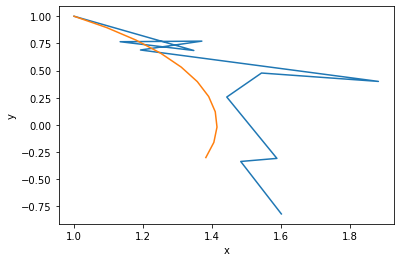

In [8]:
plt.plot(xt[0, :], xt[1, :])
plt.plot(traj[0], traj[1])
plt.xlabel('x')
plt.ylabel('y')

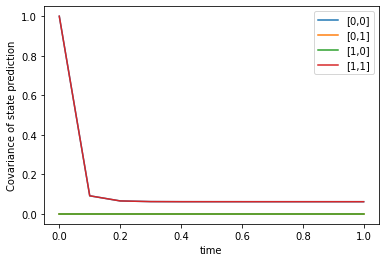

In [9]:
plt.plot(tvec, Pt[:, 0, 0], label = "[0,0]")
plt.plot(tvec, Pt[:, 0, 1], label = "[0,1]")
plt.plot(tvec, Pt[:, 1, 0], label = "[1,0]")
plt.plot(tvec, Pt[:, 1, 1], label = "[1,1]")
plt.xlabel('time')
plt.ylabel('Covariance of state prediction')
plt.legend()

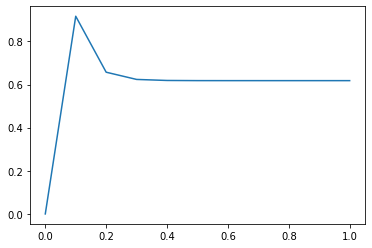

In [10]:
plt.plot(tvec, K[:, 0, 0])

In [11]:
def simulate_filter(K = False):

    # allocate result matrices
    x_pred = np.zeros((n, N+1))      # prediction of state vector
    P_pred = np.zeros((N+1, n,n))    # prediction error covariance matrix
    xt     = np.zeros((n, N+1))                  # estimation of state vector
    Pt     = np.zeros((N+1, n, n))   # estimation error covariance matrix
    Kt      = np.zeros((N+1, n, n))        # Kalman Gain
    error = np.zeros(N+1)

    # set initial prediction 
    x_pred[:, 0] = x0
    xt[:, 0]     = x0
    P_pred[0]    = P0
    Pt[0]        = P0
    
    # opt
    if not K:
        opt = True
    else:
        opt = False
        K = K * np.identity(2)


    # for  each timestep
    for i in range(1, N+1):

        # Prediction Stage
        wk = noise_distribution([0, 0], sigma)                # zero mean and variance given
        x_pred[:, i] = propogate_fwd(xt[:, i-1]) + wk
        P_pred[i] = np.linalg.multi_dot((A, Pt[i-1], A.T)) + Q

        # Kalman Gain and Measured Data
        if opt:
            Kt[i] = np.matmul(P_pred[i], C.T) @ np.linalg.inv((np.linalg.multi_dot((C, P_pred[i], C.T))+ R)) 
            K = Kt[i]
            
        vk = noise_distribution([0, 0], sigma)      # measurement noise- zero mean and variance given 
        zk = np.matmul(C, traj[:, i]) + vk       

        # Measurement Update
        xt[:, i] =  x_pred[:, i] + K @ (zk - C @ x_pred[:, i])
        Pt[i]    =  P_pred[i] - np.linalg.multi_dot((K, C, P_pred[i]))
        
        # Compute error at each timestep 
        error[i] = np.linalg.norm(traj[:,i] - xt[:, i])
    

    avg_err = np.sum(error)/len(error)
    
    return avg_err
    

In [12]:
alpha = 0.6
K_list = [0.618034]
K_list = [False]
s = [round(random.uniform(0.618034- alpha, 0.618034 + alpha), 3) for i in range(10)]
K_list = K_list + s

Avg_Error_List = []
filt_num = [i for i in range(len(K_list))]
lab = filt_num.copy()
lab[0] = "opt"


# loop through filters
data = [] 
for K in K_list:
    error = []
    # loop through sample paths
    for i in range(100):
        error.append(simulate_filter(K))
        avg_error = sum(error)/len(error)
    data.append(error)  
    Avg_Error_List.append(avg_error)
    

        

Text(0.5, 0, 'Linear Filter')

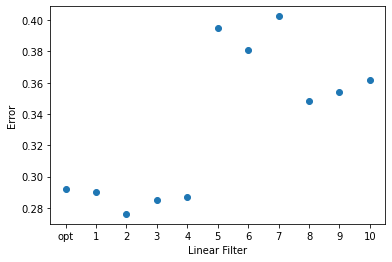

In [13]:
plt.scatter(filt_num, Avg_Error_List)
plt.xticks(filt_num, lab)
plt.ylabel('Error')
plt.xlabel('Linear Filter')

<ipython-input-14-0126c66f50e6>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lab)


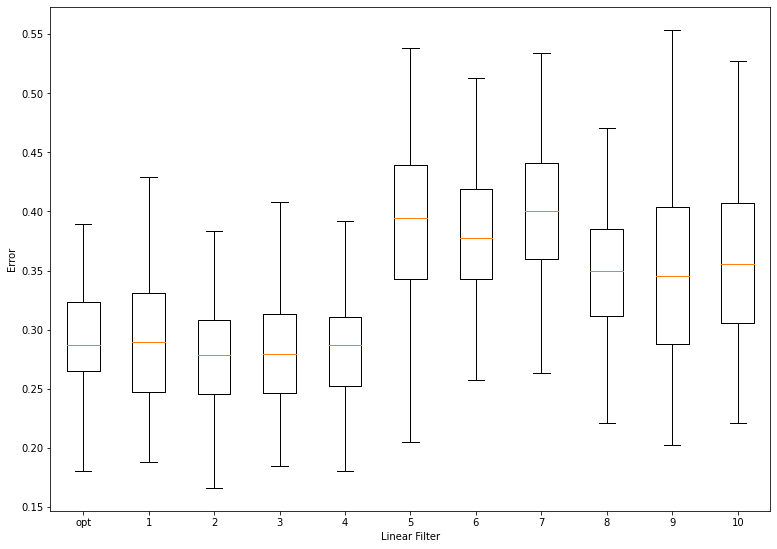

In [14]:
# boxplot
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(lab)
 
# Creating plot
bp = ax.boxplot(data, showfliers = False)
 
# show plot
plt.ylabel('Error')
plt.xlabel('Linear Filter')
plt.show()